---
title: "Test 2: Recommender Systems"
subtitle: "Machine Learning III: Unsupervised and Network Analysis"
date: "9 April 2024"
author: 
  -  María del Valle Varo García


---
---

Yago Tobio Souto (201802168)

::: {.callout-important icon=false}

No puedes utilizar ChatGPT, pero tienes pleno acceso a Internet; no dudes en utilizarlo, ya que suele ser mucho más útil para programar, mirar documentación o resolver errores de código.
:::

::: {.callout-warning icon=false}

Evita dedicar tiempo a generar código o gráficas no solicitadas. 

No se evaluarán y sólo servirán para consumir tiempo del examen.
:::

---

**WARNING: NO ME FUNCIONARON LAS FUNCIONES CON PROBLEMAS DE NUMPY, RESETEE EL KERNEL Y TODOS MIS RESULTADOS SE ME FUERON**

In [9]:
# * Librerias
import os
import sys
import time
import math
import torch
import cornac
import warnings
import operator
import itertools
import scipy.stats
import numpy as np
import pandas as pd
import torch as torch
import torch.nn as nn
import seaborn as sns
import tensorflow as tf
import scipy.sparse as sp
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data

from tabulate import tabulate
from cornac.utils import cache
from sklearn.manifold import TSNE
from adjustText import adjust_text
from collections import defaultdict
from scipy.sparse.linalg import svds
from torch.utils.data import Dataset
from numpy.linalg import matrix_rank
from cornac.datasets import movielens
from matplotlib.cbook import boxplot_stats
from cornac.eval_methods import RatioSplit

from sklearn.metrics import mean_squared_error
from elasticsearch import Elasticsearch, helpers
from sklearn.metrics.pairwise import cosine_similarity
from cornac.models import MF, NMF, BaselineOnly, BPR, WMF, UserKNN, ItemKNN, SVD

# **Análisis de ratings a Video Juegos**
### Utilizando la base de datos proporcionada que contiene información sobre usuarios, videojuegos y las calificaciones otorgadas por los usuarios a los videojuegos, realiza las siguientes tareas:




::: {.callout-tip icon="false}
### Question 0 (0.25 points)
Carga los datos como un objeto **panda.DataFrame**.
:::

In [10]:
df_path = './reduced_video_games.csv'
df_videogames = pd.read_csv(df_path, header = 0)

In [11]:
df_videogames.head()

,userId,productId,rating
0,A2BQXTSS8G6ZL2,B001TOQ8UW,5.0
1,AEJZHD61JTJKK,B0029LJIFG,5.0
2,A3TY2AEFHQRTWJ,B003O6E1JS,4.0
3,A8RITE7SJ9GYS,B0000E5U6I,3.0
4,A1SCCUZEPM657Y,B00DJFIMW6,5.0


In [12]:
len(df_videogames)

250000

In [13]:
df_videogames

,userId,productId,rating
0,A2BQXTSS8G6ZL2,B001TOQ8UW,5.0
1,AEJZHD61JTJKK,B0029LJIFG,5.0
2,A3TY2AEFHQRTWJ,B003O6E1JS,4.0
3,A8RITE7SJ9GYS,B0000E5U6I,3.0
4,A1SCCUZEPM657Y,B00DJFIMW6,5.0
...,...,...,...
249995,A1ULM4N7HV1VEM,B003AHA71M,4.0
249996,AP12LVBPNUZBP,B002I0JDP8,5.0
249997,A3JV0VL20US2HC,B007YZ5QOO,5.0
249998,A1U8S4B6AGC9B3,B002I0F5I2,5.0





::: {.callout-tip icon="false}
### Question 1 (0.75 points)
Filtra el conjunto de datos y conserva sólo los productos que hayan sido valorados al menos 20 veces.

:::

In [14]:
df_videogames_sample = df_videogames.sample(n=10000, random_state=42)

In [15]:
df_videogames_filtered = df_videogames.groupby('productId')['rating'].value_counts().loc[lambda x: x < 20].reset_index(name='count')

In [16]:
df_videogames_filtered
# ? - Pero se me ha eliminado el userId???

,productId,rating,count
0,043933702X,5.0,1
1,043940133X,5.0,2
2,0439573947,5.0,1
3,0439591368,1.0,1
4,0439591368,5.0,1
...,...,...,...
65388,B00L2Q5KWE,1.0,1
65389,B00LATX6KG,5.0,1
65390,B00LCLV730,5.0,1
65391,B00LGBJIQ4,5.0,1


::: {.callout-tip icon="false}

### Question 2 (0.25 points)

¿Qué porcentaje de los datos (ya filtrados) tiene una calificación de 4 o superior?

:::

In [17]:
list_review = []
for review in df_videogames_sample['rating']: 
    if review > 4:
        list_review.append(review)

print(f'Porcentaje de reviews superiores a 4: {round(len(list_review)/len(df_videogames_sample['rating'])*100,2)}%')

Porcentaje de reviews superiores a 4: 52.88%


::: {.callout-tip icon="false}
### Question 3 (0.25 points)

¿Cuántos usuarios únicos y productos hay?

:::

In [18]:
unique_users = df_videogames_sample['userId'].nunique()
unique_items = df_videogames_sample['productId'].nunique()

print(f'Unique users: {unique_users}\nUnique items: {unique_items}')

Unique users: 9809
Unique items: 5747


::: {.callout-tip icon="false}
### Question 4 (0.25 points)

¿Qué porcentaje de valores atípicos hay?

:::

In [19]:
def explore_outliers(df, num_vars):
    """
    Explora y identifica los valores atípicos de variables numéricas en un DataFrame.

    Retorna:
    - outliers_df (diccionario): Diccionario con las variables numéricas como claves. Cada valor es otro diccionario
      con las claves 'values' (valores atípicos), 'positions' (posiciones de los valores atípicos en el DataFrame)
      e 'indices' (índices de los valores atípicos en el DataFrame).
    """
    outliers_df = dict()
    for k in range(len(num_vars)):
        var = num_vars[k]
        sns.boxplot(df, x=var)
        outliers_df[var] = boxplot_stats(df[var])[0][
            "fliers"
        ]  # ? - Boxplot de TODOS LOS RATINGS EN NUESTRA MUESTRA
        out_pos = np.where(df[var].isin(outliers_df[var]))[0].tolist()
        out_idx = [df[var].index.tolist()[k] for k in out_pos]
        outliers_df[var] = {
            "values": outliers_df[var],
            "positions": out_pos,
            "indices": out_idx,
        }
    return outliers_df

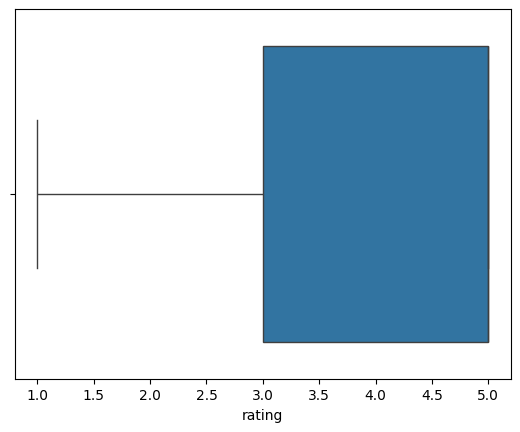

In [20]:
outlier_ratings = explore_outliers(df_videogames_sample, ['rating'])

In [21]:
print(
    "Percentage of outliers:",
    round(len(outlier_ratings.get("rating").get("indices")) / len(df_videogames_sample), 3) * 100,
    "%",
)

Percentage of outliers: 0.0 %


::: {.callout-tip icon="false}
### Question 5 (1 points)

¿Cuál es la dispersión (sparsity) del conjunto de datos antes y después de filtrar los productos con más de 20 valoraciones? 

¿Es de esperar que los recomendadores memory-based funcionen mejor que los model-based conociendo ahora la dispersión?


:::

In [22]:
def print_sparsity(df):
    n_users = df.userId.nunique()
    n_items = df.productId.nunique()
    n_ratings = len(df)
    rating_matrix_size = n_users * n_items
    sparsity = 1 - n_ratings / rating_matrix_size

    print(f"Number of users: {n_users}")
    print(f"Number of items: {n_items}")
    print(f"Number of available ratings: {n_ratings}")
    print(f"Number of all possible ratings: {rating_matrix_size}")
    print("-" * 40)
    print(f"SPARSITY: {sparsity * 100.0:.2f}%")

In [23]:
print_sparsity(df_videogames)

Number of users: 206770
Number of items: 31263
Number of available ratings: 250000
Number of all possible ratings: 6464250510
----------------------------------------
SPARSITY: 100.00%


In [24]:
# ? - Sparsity post-filtrado
print_sparsity(df_videogames_sample)

Number of users: 9809
Number of items: 5747
Number of available ratings: 10000
Number of all possible ratings: 56372323
----------------------------------------
SPARSITY: 99.98%


¿Es de esperar que los recomendadores memory-based funcionen mejor que los model-based conociendo ahora la dispersión?

**Answer**: Los modelos model-based funcionarán mejor que los memory-based a la hora de lidiar con datos dispersos, debido a como funciónan con reducción de dimensionalidades y vectores latentes



::: {.callout-tip icon="false}
### Question 6 (0.75 points)

¿Cuál es el producto menos valorado? ¿Cuántas veces ha sido valorado?


:::

Supongo que tendría que hacer el mean rating

In [25]:
ratings_matrix = df_videogames_sample.pivot_table(
    index = 'userId', 
    columns = 'productId', 
    values='rating'
)
df = ratings_matrix
df.head()

productId,7100027950,7293000936,8565000168,8990289440,9576991803,9625992421,9861019731,9882106463,9882155456,B000006OVE,...,B00JM3R6M6,B00JQ8YH6A,B00JQHU9RC,B00JU9O05S,B00K4KE7J6,B00KDNFG9Y,B00KDV3ZB2,B00KHUF0KI,B00KINYVC2,B00LGBKSK4
userId,,,,,,,,,,,,,,,,,,,,,
A005481137I9SCAWEF7ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A04375362X8C8RW9YEG2L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A046026536L7ZRCI1RCGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0612709206V88QFL5NGX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A066010017AGU5GEHA7TJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_T = df.T
df_T.head()

userId,A005481137I9SCAWEF7ON,A04375362X8C8RW9YEG2L,A046026536L7ZRCI1RCGS,A0612709206V88QFL5NGX,A066010017AGU5GEHA7TJ,A07047842IR9Y89DH0UA1,A08139842TZNAAO6X3XI1,A08324222HTYZDE4L3F8Z,A100O5QLORBZRO,A101EEOCU0H6E9,...,AZVGRCM9JLSDV,AZVLEZEB6WZFE,AZWFF8U969N2C,AZWHBFU7UJF41,AZWIQDC9S1KEM,AZXTNZR2BZTYD,AZXU8S0UUERGL,AZXWP83KBEA7N,AZYAVPUWR7LQE,AZYUVOOMRJKIC
productId,,,,,,,,,,,,,,,,,,,,,
7100027950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7293000936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8565000168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8990289440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9576991803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_T['mean_rating'] = df_T.mean(axis=1)
df_T.head()

userId,A005481137I9SCAWEF7ON,A04375362X8C8RW9YEG2L,A046026536L7ZRCI1RCGS,A0612709206V88QFL5NGX,A066010017AGU5GEHA7TJ,A07047842IR9Y89DH0UA1,A08139842TZNAAO6X3XI1,A08324222HTYZDE4L3F8Z,A100O5QLORBZRO,A101EEOCU0H6E9,...,AZVLEZEB6WZFE,AZWFF8U969N2C,AZWHBFU7UJF41,AZWIQDC9S1KEM,AZXTNZR2BZTYD,AZXU8S0UUERGL,AZXWP83KBEA7N,AZYAVPUWR7LQE,AZYUVOOMRJKIC,mean_rating
productId,,,,,,,,,,,,,,,,,,,,,
7100027950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
7293000936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
8565000168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8990289440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
9576991803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


In [28]:
lowest_ratings_df = df_T[df_T.mean_rating == df_T.mean_rating.min()]
lowest_ratings_df
# ? - Cogemos por ejemplo el: B0007UQ0O8

userId,A005481137I9SCAWEF7ON,A04375362X8C8RW9YEG2L,A046026536L7ZRCI1RCGS,A0612709206V88QFL5NGX,A066010017AGU5GEHA7TJ,A07047842IR9Y89DH0UA1,A08139842TZNAAO6X3XI1,A08324222HTYZDE4L3F8Z,A100O5QLORBZRO,A101EEOCU0H6E9,...,AZVLEZEB6WZFE,AZWFF8U969N2C,AZWHBFU7UJF41,AZWIQDC9S1KEM,AZXTNZR2BZTYD,AZXU8S0UUERGL,AZXWP83KBEA7N,AZYAVPUWR7LQE,AZYUVOOMRJKIC,mean_rating
productId,,,,,,,,,,,,,,,,,,,,,
8565000168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
B00000IJVY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
B00000JDDY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
B00000JDFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
B00000K4E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00IAZP28W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
B00IVJ1M7M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
B00IXHP3A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [29]:
print(f"El juego: B002NIP6X8 ha sido valorado {len(games.get_group('B002NIP6X8'))} veces")

NameError: name 'games' is not defined

::: {.callout-tip icon=true}

### Question 7 (0.75 points)

Haz un histograma de las valoraciones del segundo producto más valorado.

¿Cuál es la valoración media de este producto entre todos los usuarios?

:::

In [ ]:
highest_ratings_df = df_T.sort_values(by=['mean_rating'])
highest_ratings_df.head(2)

userId,A00166281YWM98A3SVD55,A00875592Z7LISWIUI55S,A01871002PTDAX315IZP3,A02343532EER409UDAGA8,A02404611VRVDT0E8KV0A,A04417582U57GA741Z19V,A046026536L7ZRCI1RCGS,A049511737EMTVGTZXNKV,A08139842TZNAAO6X3XI1,A09925812HMP7Z9FHJ810,...,AZTJ5UDLVTQ9Y,AZUQRIZVQL6ZB,AZVJAZ1WT6X90,AZXDH54YVKMQH,AZXV291VIFP9M,AZY7YVOUIBM8Q,AZZ1891TOR7NG,AZZ447TDAT01Y,AZZ5HNU9B49Q4,mean_rating
productId,,,,,,,,,,,,,,,,,,,,,
B001TOQ8WU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
B00CTKHZI4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


B007FTE2VW is the second lowest rated game.

Mean rating across all users: 1.507692

In [ ]:
row = df_videogames_filtered[df_videogames_filtered['productId'] == 'B007FTE2VW']

ValueError: cannot convert float NaN to integer

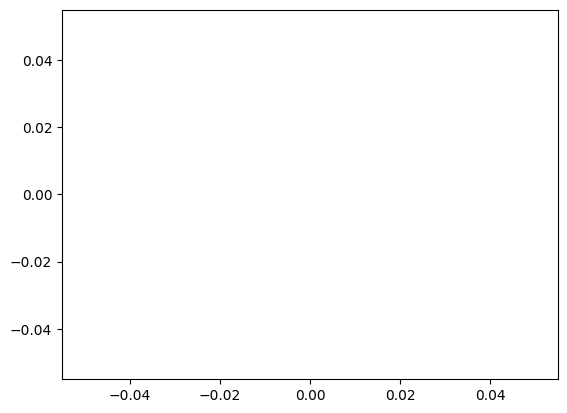

In [ ]:
# * Histograma
sns.histplot(
    x='rating', binwidth=0.5, data=row
)

::: {.callout-tip icon=true}

### Question 8 (1.0 points)

Haz varios sistemas de recomendación **User-Based** para este conjunto de datos para `k=30` vecinos.

Compara la similitud Pearson con la similitud Coseno. ¿Ayuda el centrado medio?

Comprueba diferentes métricas: RMSE, MAE, Precisión.
:::

In [ ]:
df_videogames_sample = df_videogames.sample(n=10000, random_state=42, ignore_index=True)

In [ ]:
def userknn_cornac(df: pd.DataFrame):

    df = df.astype({"userId": object, "productId": object})
    df.to_numpy()
    records = df.to_records(index=False)
    result = list(records)

    K = 30  # number of nearest neighbors
    VERBOSE = False
    SEED = 42
    uknn_cosine = UserKNN(
        k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE
    )
    uknn_cosine_mc = UserKNN(
        k=K,
        similarity="cosine",
        mean_centered=True,
        name="UserKNN-Cosine-MC",
        verbose=VERBOSE,
    )
    uknn_pearson = UserKNN(
        k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE
    )
    uknn_pearson_mc = UserKNN(
        k=K,
        similarity="pearson",
        mean_centered=True,
        name="UserKNN-Pearson-MC",
        verbose=VERBOSE,
    )

    # Metrics
    rec_300 = cornac.metrics.Recall(k=300)
    rec_900 = cornac.metrics.Recall(k=900)
    prec_30 = cornac.metrics.Precision(k=30)
    rmse = cornac.metrics.RMSE()
    mae = cornac.metrics.MAE()

    ratio_split = RatioSplit(result, test_size=0.2, seed=SEED, verbose=VERBOSE)
    cornac.Experiment(
        eval_method=ratio_split,
        models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
        metrics=[rec_300, rec_900, prec_30, rmse, mae],
    ).run()

    userknn_models = {
        "uknn_cosine": uknn_cosine,
        "uknn_cosine_mc": uknn_cosine_mc,
        "uknn_pearson": uknn_pearson,
        "uknn_pearson_mc": uknn_pearson_mc,
    }

    return userknn_models

In [ ]:
userknn_models = userknn_cornac(df_videogames_sample)  # ? - Returns the data with the Metrics

::: {.callout-tip icon=true}

### Question 9 (0.75 points)

Selecciona un usuario y recomiendale los 10 mejores productos basándote en el modelo de user-based que consideres oportuno dado el entrenamiento.

:::

In [ ]:
# * Predicción de score para cualquier producto:
def uknn_get_scores(UID, model, user_df, TOPK=5):

    UIDX = list(model.train_set.uid_map.items())[UID][0]
    recommendations, scores = model.rank(UID)
    print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UIDX}:")
    print("Scores:", scores[recommendations[:TOPK]])
    print(user_df.iloc[recommendations[:TOPK]])

In [ ]:
# model to determine, pero visto el sesgo de ratings hacia el 5
# voy a seleccionar el de pearson 
model = userknn_models.get('uknn_pearson_mc')
uknn_get_scores(2, model, users)

::: {.callout-tip icon=true}

### Question 10 (1.0 points)
Haz varios sistemas de recomendación **Item-based** para este conjunto de datos para `k=30` vecinos.

Compara la similitud Pearson, la similitud Coseno ajustado y la similitud Coseno. ¿Ayuda el centrado medio?

Comprueba diferentes métricas: RMSE, MAE, Precisión.
:::

In [ ]:
def itemknn_cornac(df):
    df = df.astype({"userId": object, "productId": object})
    records = df.to_records(index=False)
    result = list(records)
    K = 50  # number of nearest neighbors
    VERBOSE = False
    SEED = 42
    iknn_cosine = ItemKNN(
        k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
    )
    iknn_cosine_mc = ItemKNN(
        k=K,
        similarity="cosine",
        mean_centered=True,
        name="ItemKNN-Cosine-MC",
        verbose=VERBOSE,
    )
    iknn_pearson = ItemKNN(
        k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
    )
    iknn_pearson_mc = ItemKNN(
        k=K,
        similarity="pearson",
        mean_centered=True,
        name="ItemKNN-Pearson-MC",
        verbose=VERBOSE,
    )

    # Metrics
    rmse = cornac.metrics.RMSE()
    mae = cornac.metrics.MAE()

    ratio_split = RatioSplit(result, test_size=0.2, seed=SEED, verbose=VERBOSE)
    cornac.Experiment(
        eval_method=ratio_split,
        models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_cosine_mc],
        metrics=[rmse, mae],
    ).run()
    itemknn_models = {
        "iknn_cosine": iknn_cosine,
        "iknn_pearson": iknn_pearson,
        "iknn_pearson_mc": iknn_pearson_mc,
        "iknn_cosine_mc": iknn_cosine_mc,
    }
    return itemknn_models

In [ ]:
itemknn_models = itemknn_cornac(df_videogames_sample)

::: {.callout-tip icon=true}

### Question 11 (0.75 points)

Convierte la matriz de ratings pronosticadas en el entrenamiento de tu modelo **Item-Based** favorito en un objeto `pd.DataFrame`.
:::

::: {.callout-tip icon=true}

### Question 12 (0.75 points)

¿Qué puntuación recibe el artículo `'B002I098JE` del usuario `'A7B5JEED0RKXG'` según este modelo?

¿Y según el model User-based?

:::

::: {.callout-tip icon=true}

### Question 13 (1 points)

Haz un sistema de recomendación utilizando SVD para este dataset con k=100, otro para k=150 y otro para k=200. 

:::

In [ ]:
# * - Función para generar el módelo SVD
def svd_cornac(df, k_min=100, k_max=200, step=50):
    """
    Ejecuta experimentos SVD para un rango de valores de 'k' sobre un DataFrame utilizando Cornac.

    Devuelve:
    - (lista, cornac.Experiment): Lista de modelos SVD entrenados y el objeto experimento con los resultados.

    """
    df = df.astype({"userId": object, "productId": object})
    records = df.to_records(index=False)
    result = list(records)

    VERBOSE = False
    SEED = 42

    svd_models = []
    k_values = np.arange(k_min, k_max, step)
    for k in k_values:
        svd_models.append(
            SVD(
                name="SVD" + str(k),
                k=k,
                max_iter=30,
                learning_rate=0.01,
                lambda_reg=0.02,
                verbose=True,
            )
        )

    # Metrics
    rmse = cornac.metrics.RMSE()
    mae = cornac.metrics.MAE()

    ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
    svd_experiment = cornac.Experiment(
        eval_method=ratio_split,
        models=svd_models,
        show_validation=True,
        metrics=[rmse, mae],
    )
    svd_experiment.run()

    return svd_models, svd_experiment


In [ ]:
svd_models, svd_experiment = svd_cornac(df_videogames_sample)

::: {.callout-tip icon=true}

### Question 14 (0.75 points)

Selecciona uno de los modelos de SVD, elige a un usuario y recomiéndale 5 productos, luego imprime las puntuaciones que les otorgaría a esos productos.

:::

In [ ]:
def plot_rmse_cornac(experiment, metric_name="RMSE"):
    metric_values = []
    names_models = []
    for i in range(len(experiment.result)):
        metric_values.append(
            svd_experiment.result[i].metric_avg_results.get(metric_name)
        )
        names_models.append(svd_experiment.result[i].model_name)

    plt.xlabel("Latent Dimensions")
    plt.ylabel("RMSE")
    plt.title("SVD")
    plt.plot(names_models, metric_values, "o-")
    plt.show()

In [ ]:
plot_rmse_cornac(svd_experiment)
# ? - De aqui sacamos el mejor latent space SVD de los 3

In [ ]:
# * Función para recomendar a un usuario mediante el indice su producto
def recommend_products(index, model, data, num_products=5):

    print(
        "Name of Model:", svd_models[n].name
    )  # ? - Sustituir el n, por el indice del modelo con menor RMSE

    # Rank all test items for a given user.
    df_rank = pd.DataFrame(
        {"ranked_items": model.rank(index)[0], "item_scores": model.rank(index)[1]},
        columns=["ranked_items", "item_scores"],
    )
    print(
        "Target UserId", df_sample.iloc[index].UserId
    )  # * Cuidado aqui con el df_smaple

    df_rank.sort_values("item_scores", ascending=False, inplace=True)

    print(
        "Recommended products:",
        data.iloc[df_rank.head(num_products).ranked_items.values]["ProductId"].values,
    )
    print("Predicted scoreds: ", df_rank.head(num_products).item_scores.values)

In [ ]:
recommend_products(1, svd_models[n], df_videogames_sample)